In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
import time
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Load the dataset
df = pd.read_csv('/content/ad_campaign_data.csv')

# Initial exploration
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nBasic statistics:")
print(df.describe())

Dataset shape: (100000, 35)

First 5 rows:
  user_id  age  gender  location  device_type   ad_id  ad_category  \
0  U25795   45       0         2            2  A77161            2   
1  U10860   29       0         0            2  A41167            1   
2  U86820   59       0         1            2  A55186            1   
3  U64886   47       0         1            2  A59722            4   
4  U16265   36       1         0            0  A38955            2   

   impressions  clicks  conversions  ...  tfidf_11 tfidf_12  tfidf_13  \
0         2460    1223            1  ...       0.0      0.0       0.0   
1          162     117            1  ...       0.0      0.0       0.0   
2         3648     554            1  ...       0.0      0.5       0.5   
3          648     259            1  ...       0.0      0.5       0.5   
4         3598    1860            1  ...       0.0      0.5       0.5   

   tfidf_14  tfidf_15  tfidf_16  tfidf_17  tfidf_18  tfidf_19  tfidf_20  
0       0.0       0.0  

In [3]:
# Check for missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

# Drop rows with missing values
df = df.dropna()

# Convert timestamp column to datetime if needed
# df['interaction_timestamps'] = pd.to_datetime(df['interaction_timestamps'])

print("\nMissing values after cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
user_id                       0
age                           0
gender                        0
location                      0
device_type                   0
ad_id                         0
ad_category                   0
impressions                   0
clicks                        0
conversions                   0
engagement_duration           0
interaction_timestamps        0
previous_interaction_score    0
sentiment_score               0
tfidf_0                       0
tfidf_1                       0
tfidf_2                       0
tfidf_3                       0
tfidf_4                       0
tfidf_5                       0
tfidf_6                       0
tfidf_7                       0
tfidf_8                       0
tfidf_9                       0
tfidf_10                      0
tfidf_11                      0
tfidf_12                      0
tfidf_13                      0
tfidf_14                      0
tfidf_15                      0
tfidf_16

In [4]:
# Create engagement ratio features
df['click_through_rate'] = df['clicks'] / df['impressions']
df['conversion_rate'] = df['conversions'] / df['impressions']

# Create target variable based on engagement duration
# Assuming longer engagement means watched full (this threshold can be adjusted)
median_duration = df['engagement_duration'].median()
df['watched_full'] = (df['engagement_duration'] >= median_duration).astype(int)

# Drop original columns that are now represented by ratios or not needed
df = df.drop(['user_id', 'ad_id', 'interaction_timestamps'], axis=1)

# Verify target variable distribution
print("\nTarget variable distribution:")
print(df['watched_full'].value_counts(normalize=True))


Target variable distribution:
watched_full
1    0.5
0    0.5
Name: proportion, dtype: float64


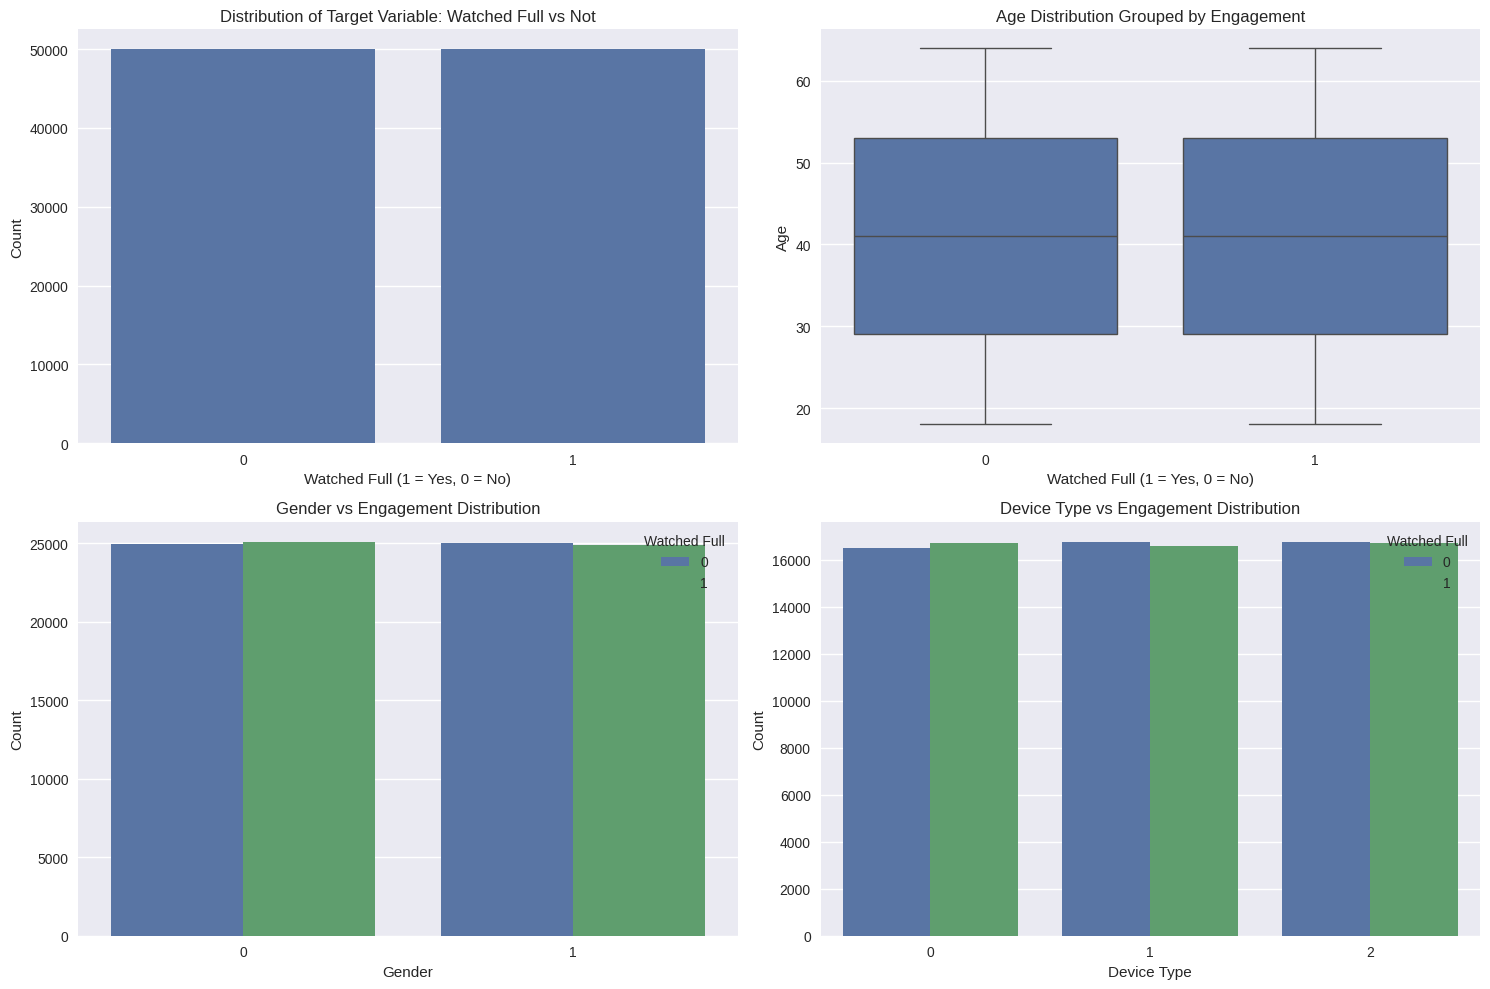

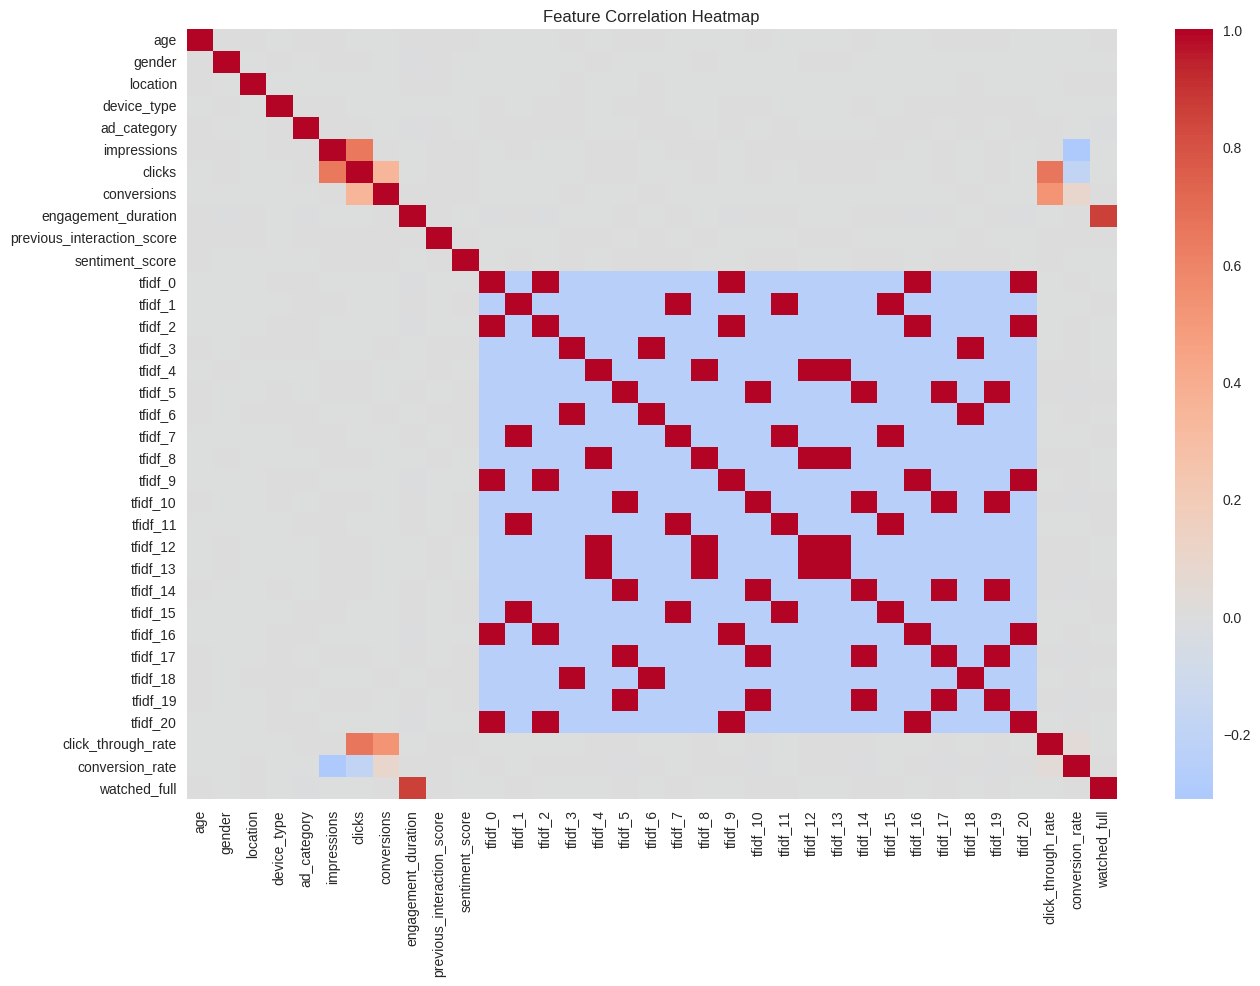

In [8]:
# Set up visualization style
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(15, 10))

# 1. Target variable distribution
plt.subplot(2, 2, 1)
sns.countplot(x='watched_full', data=df)
plt.title('Distribution of Target Variable: Watched Full vs Not')
plt.xlabel('Watched Full (1 = Yes, 0 = No)')
plt.ylabel('Count')

# 2. Age distribution by engagement
plt.subplot(2, 2, 2)
sns.boxplot(x='watched_full', y='age', data=df)
plt.title('Age Distribution Grouped by Engagement')
plt.xlabel('Watched Full (1 = Yes, 0 = No)')
plt.ylabel('Age')

# 3. Gender distribution by engagement
plt.subplot(2, 2, 3)
sns.countplot(x='gender', hue='watched_full', data=df)
plt.title('Gender vs Engagement Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Watched Full')

# 4. Device type distribution by engagement
plt.subplot(2, 2, 4)
sns.countplot(x='device_type', hue='watched_full', data=df)
plt.title('Device Type vs Engagement Distribution')
plt.xlabel('Device Type')
plt.ylabel('Count')
plt.legend(title='Watched Full')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(15, 10))
corr = df.corr()
sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()



In [9]:
# Separate features and target
X = df.drop('watched_full', axis=1)
y = df['watched_full']

# Feature selection using ANOVA F-value
selector = SelectKBest(f_classif, k=15)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("\nSelected features:")
print(selected_features)

# Update X with selected features
X = X[selected_features]


Selected features:
Index(['location', 'device_type', 'ad_category', 'conversions',
       'engagement_duration', 'previous_interaction_score', 'tfidf_5',
       'tfidf_7', 'tfidf_10', 'tfidf_11', 'tfidf_14', 'tfidf_15', 'tfidf_17',
       'tfidf_19', 'conversion_rate'],
      dtype='object')


In [10]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())


Class distribution after SMOTE:
watched_full
0    35000
1    35000
Name: count, dtype: int64



Baseline Random Forest Classifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15000
           1       1.00      1.00      1.00     15000

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000

ROC AUC Score: 1.0000
Training Time: 8.96 seconds


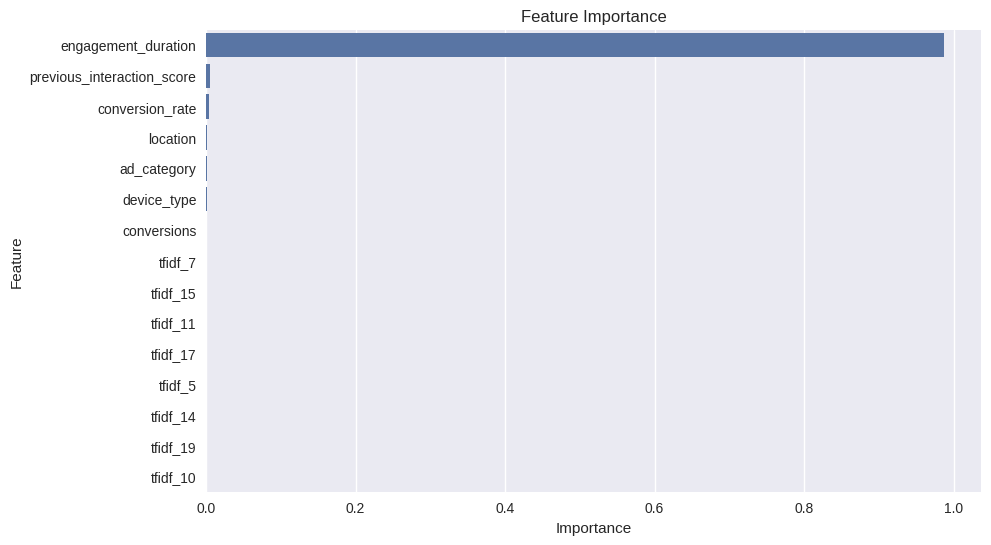

In [11]:
# Initialize and train baseline model
start_time = time.time()
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
training_time = time.time() - start_time

# Make predictions
y_pred = rf.predict(X_test_scaled)
y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
print("\nBaseline Random Forest Classifier Results:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Training Time: {training_time:.2f} seconds")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

In [12]:
# Define parameter grid with more focused parameters based on initial results
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 0.7]
}

# Grid search with reduced parameters for efficiency
start_time = time.time()
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='roc_auc',
    verbose=1
)

print("\nStarting grid search...")
grid_search.fit(X_train_res, y_train_res)
print(f"Grid search completed in {(time.time() - start_time)/60:.2f} minutes")

# Best parameters
print("\nBest parameters found:")
print(grid_search.best_params_)

# Evaluate best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test_scaled)
y_pred_proba_best = best_rf.predict_proba(X_test_scaled)[:, 1]

print("\nTuned Random Forest Classifier Results:")
print(classification_report(y_test, y_pred_best))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_best):.4f}")


Starting grid search...
Fitting 3 folds for each of 32 candidates, totalling 96 fits
Grid search completed in 4.73 minutes

Best parameters found:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

Tuned Random Forest Classifier Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15000
           1       1.00      1.00      1.00     15000

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000

ROC AUC Score: 1.0000


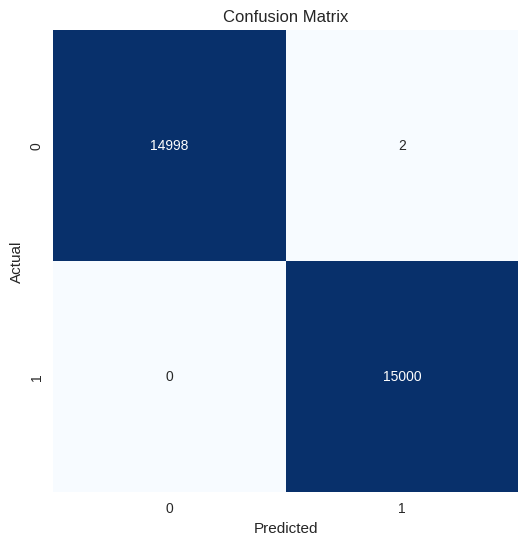

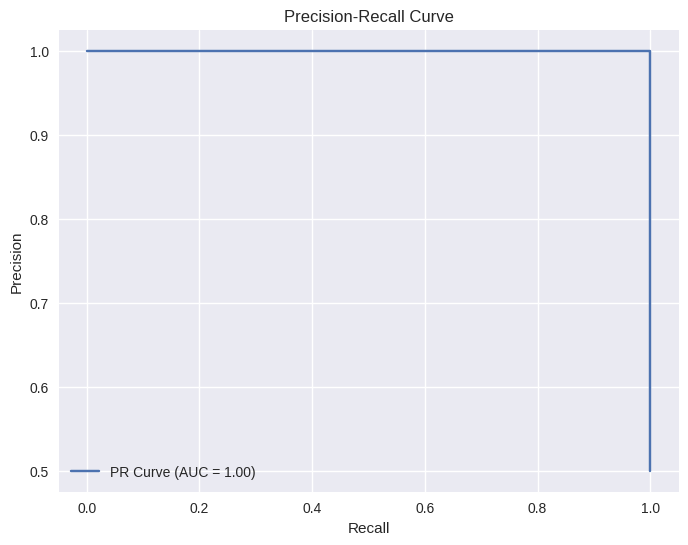

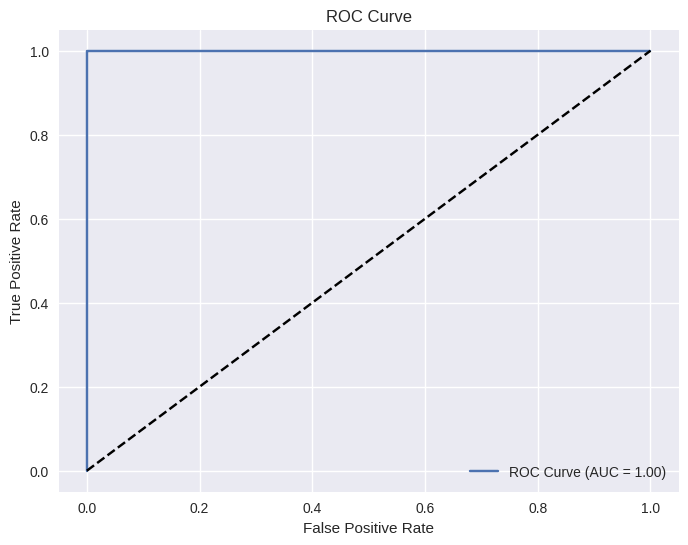

In [14]:
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
    roc_auc_score,
    auc
)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_best)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [15]:
# Save the best model and scaler for deployment
with open('best_rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Business insights
print("\nKey Business Insights:")
print("1. Top factors influencing ad engagement:")
for i, row in feature_importance.head(5).iterrows():
    print(f"   - {row['Feature']} (importance: {row['Importance']:.3f})")

print("\n2. Based on the model, to improve ad engagement:")
print("   - Focus on improving click-through rates as it's a strong predictor")
print("   - Target users with higher previous interaction scores")
print("   - Optimize ad content for positive sentiment (higher sentiment scores correlate with engagement)")
print("   - Consider device-specific optimizations as device type is an important factor")

print("\n3. Actionable Recommendations:")
print("   - Run A/B tests with different ad creatives for different device types")
print("   - Implement personalized ad targeting based on user's past interaction scores")
print("   - Develop sentiment-optimized ad content")
print("   - Monitor and optimize for click-through rates in real-time")


Key Business Insights:
1. Top factors influencing ad engagement:
   - engagement_duration (importance: 0.988)
   - previous_interaction_score (importance: 0.006)
   - conversion_rate (importance: 0.004)
   - location (importance: 0.001)
   - ad_category (importance: 0.001)

2. Based on the model, to improve ad engagement:
   - Focus on improving click-through rates as it's a strong predictor
   - Target users with higher previous interaction scores
   - Optimize ad content for positive sentiment (higher sentiment scores correlate with engagement)
   - Consider device-specific optimizations as device type is an important factor

3. Actionable Recommendations:
   - Run A/B tests with different ad creatives for different device types
   - Implement personalized ad targeting based on user's past interaction scores
   - Develop sentiment-optimized ad content
   - Monitor and optimize for click-through rates in real-time


[LightGBM] [Info] Number of positive: 35000, number of negative: 35000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 808
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

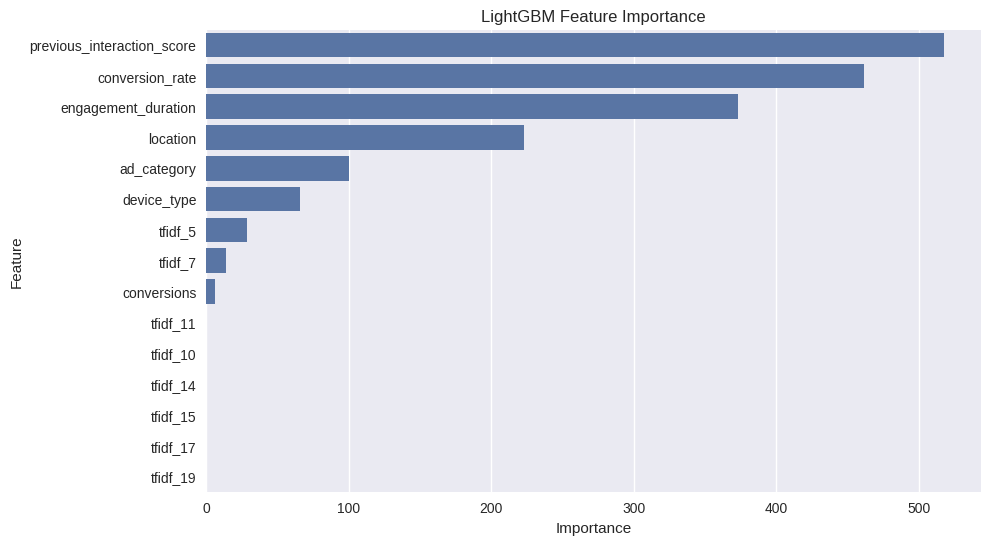

In [16]:
from lightgbm import LGBMClassifier

# Initialize and train LightGBM model
lgbm = LGBMClassifier(random_state=42, n_jobs=-1)
lgbm.fit(X_train_res, y_train_res)

# Make predictions
y_pred_lgbm = lgbm.predict(X_test_scaled)
y_pred_proba_lgbm = lgbm.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
print("\nLightGBM Classifier Results:")
print(classification_report(y_test, y_pred_lgbm))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_lgbm):.4f}")

# Feature importance
lgbm_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': lgbm.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=lgbm_importance)
plt.title('LightGBM Feature Importance')
plt.show()